In [1]:
import yt

ds = yt.load("testdata/diffusionplot")

ds.field_list

yt : [INFO     ] 2021-05-26 11:03:21,592 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-05-26 11:03:21,594 Parameters: domain_dimensions         = [ 60  50 100]
yt : [INFO     ] 2021-05-26 11:03:21,595 Parameters: domain_left_edge          = [-1.         -0.83333333 -1.66666667]
yt : [INFO     ] 2021-05-26 11:03:21,596 Parameters: domain_right_edge         = [1.         0.83333333 1.66666667]


[('boxlib', 'concentration'), ('boxlib', 'phase')]

yt : [INFO     ] 2021-05-26 11:03:22,297 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:22,298 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:22,303 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:22,304 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:22,306 Making a fixed resolution buffer of (('boxlib', 'concentration')) 800 by 800



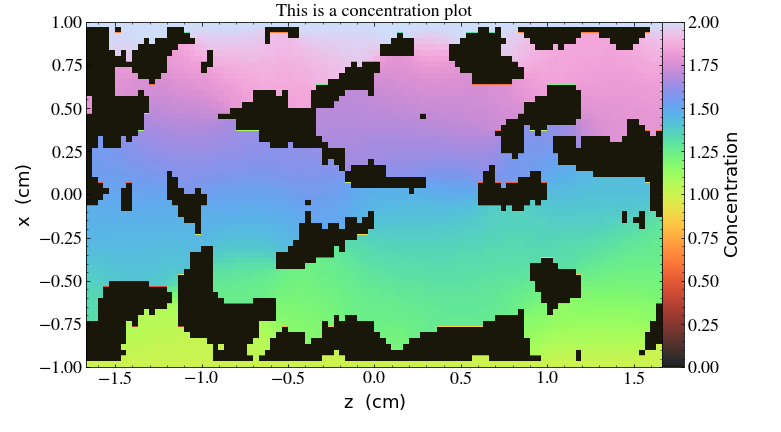

In [2]:
slc = yt.SlicePlot(ds, "y", "concentration")
slc.annotate_title('This is a concentration plot')
slc.set_log("concentration", False)
slc.set_log("phase", True)
ax = slc.plots['concentration'].axes
ax.set_ylim(1,2)
#slc.annotate_contour("concentration")
slc.set_cmap("concentration", "kamae")

slc.show()


yt : [INFO     ] 2021-05-26 11:03:23,658 Projection completed
yt : [INFO     ] 2021-05-26 11:03:23,660 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:23,660 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:23,662 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:23,662 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:23,665 Making a fixed resolution buffer of (('boxlib', 'concentration')) 800 by 800
yt : [INFO     ] 2021-05-26 11:03:23,713 Making a fixed resolution buffer of (('boxlib', 'phase')) 800 by 800



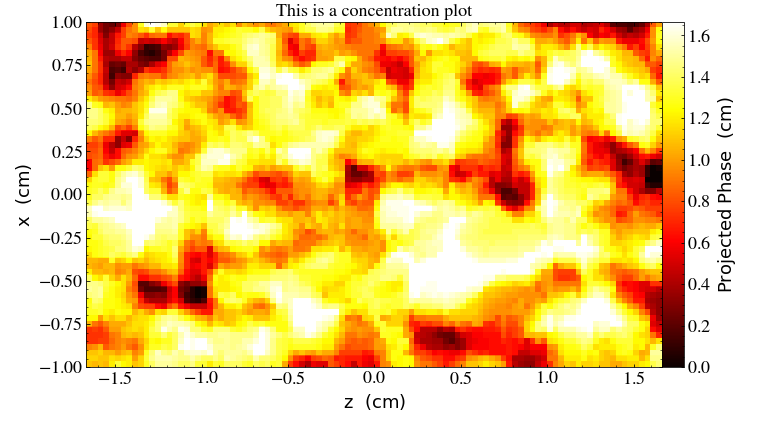
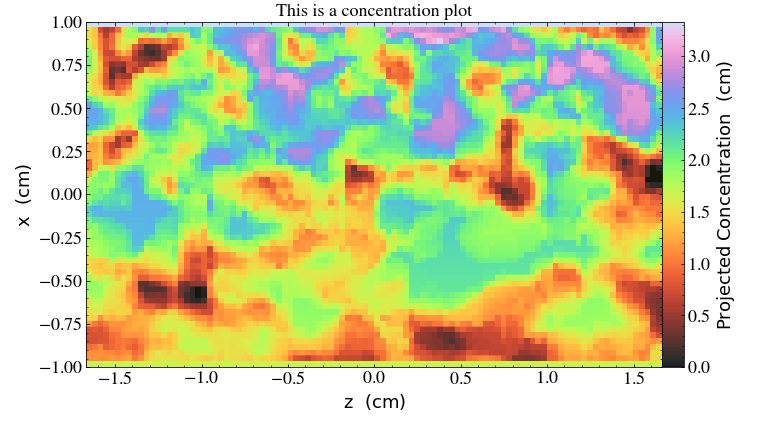

In [3]:
slc = yt.ProjectionPlot(ds, "y", ["concentration","phase"])
slc.annotate_title('This is a concentration plot')
slc.set_log("concentration", False)
slc.set_log("phase", False)
#ax = slc.plots['concentration'].axes
#ax.set_ylim(-1,1)
#slc.annotate_contour("concentration")
slc.set_cmap("concentration", "kamae")
slc.set_cmap("phase", "hot")
#for phase in slc : 
#    if phase==1: slc.set_cmap("phase", "bone")
    


slc.show()

yt : [INFO     ] 2021-05-26 11:03:26,689 Projection completed
yt : [INFO     ] 2021-05-26 11:03:26,690 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:26,691 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:26,693 xlim = -1.666667 1.666667
yt : [INFO     ] 2021-05-26 11:03:26,700 ylim = -1.000000 1.000000
yt : [INFO     ] 2021-05-26 11:03:26,703 Making a fixed resolution buffer of (('boxlib', 'concentration')) 800 by 800



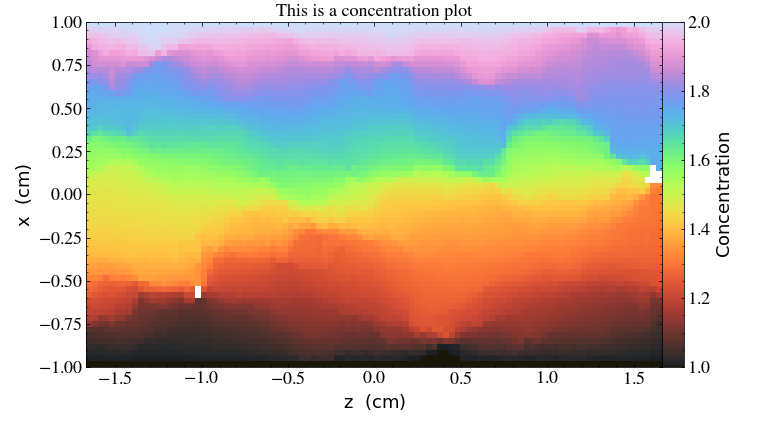

In [4]:
slc = yt.ProjectionPlot(ds, "y", "concentration", weight_field="phase")
slc.annotate_title('This is a concentration plot')
slc.set_log("concentration", False)
slc.set_log("phase", False)
#ax = slc.plots['concentration'].axes
#ax.set_ylim(-1,1)
#slc.annotate_contour("concentration")
slc.set_cmap("concentration", "kamae")
#for phase in slc : 
#    if phase==1: slc.set_cmap("phase", "bone")
    


slc.show()

yt : [INFO     ] 2021-05-26 11:03:27,767 Rendering scene (Can take a while).
yt : [INFO     ] 2021-05-26 11:03:27,866 Creating volume
/home/jovyan/.local/lib/python3.7/site-packages/unyt/array.py:1674: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/home/jovyan/.local/lib/python3.7/site-packages/unyt/array.py:1674: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
yt : [INFO     ] 2021-05-26 11:03:27,938 Creating transfer function


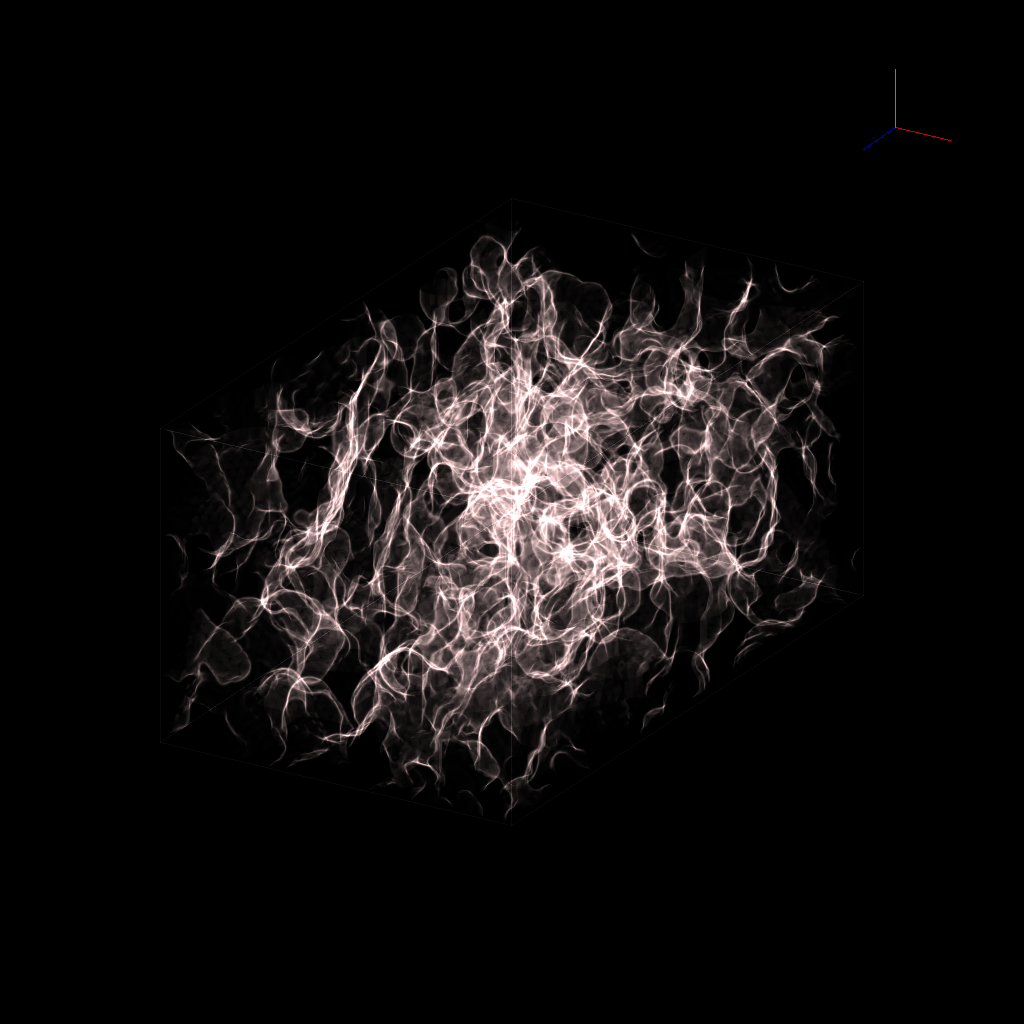

In [5]:
sc = yt.create_scene(ds, field="phase")
source = sc[0]
source.tfh.set_bounds((0.000000000001, 1))
source.tfh.set_log(True)
source.tfh.grey_opacity = True
sc.camera.resolution = 1024
sc.camera.switch_orientation()
sc.annotate_axes(alpha=.5)
sc.annotate_domain(ds, color=[1, 1, 1, 0.1])
sc.show(sigma_clip = 3)

yt : [INFO     ] 2021-05-26 11:03:47,466 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2021-05-26 11:03:47,507 Rendering scene (Can take a while).
yt : [INFO     ] 2021-05-26 11:03:47,521 Creating volume


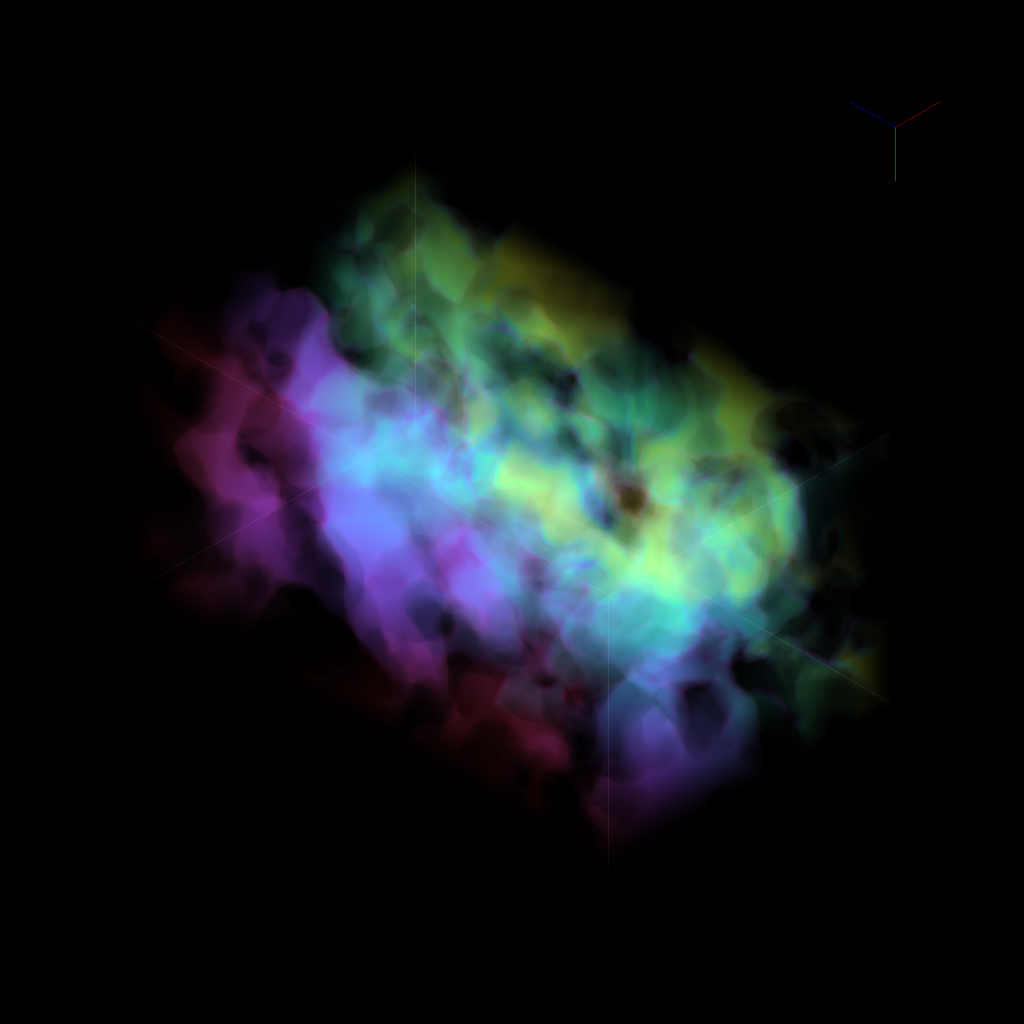

In [6]:
sc = yt.create_scene(ds, field="concentration")


source = sc[0]

source.set_field('concentration')
source.set_log(False)
source.tfh.grey_opacity = True

bounds = (1 ,2)
sc.camera.focus = ds.domain_center
sc.camera.resolution = 1024
sc.camera.north_vector = [0, -1, 0]
sc.camera.position = [-1, -1, -1]
slc.set_log("concentration", False)
slc.set_log("phase", False)

ax = slc.plots['concentration'].axes

# Since this rendering is done in log space, the transfer function needs
# to be specified in log space.
tf= yt.ColorTransferFunction(bounds)

render_source = sc.get_source()
render_source.transfer_function.clear()
render_source.transfer_function.map_to_colormap(
    (ds.quan(1.0)),
    (ds.quan(2.0)),
    scale=5.0, colormap='arbre')
#tf.add_layers(2, colormap='arbre')

#source.tfh.tf = tf
#source.tfh.bounds = bounds
sc.annotate_axes(alpha=.5)
sc.annotate_domain(ds, color=[1, 1, 1, 0.1])

sc.show(sigma_clip = 3)
